In [1]:
from qiskit import *
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_distribution
import numpy as np, matplotlib.pyplot as plt

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

*Shor's Algorithm* is a quantum algorithm for **integer factorization,** which solves the following problem:

Given an integer $N$, find its prime factors. The algorithm runs in polynomial time, while the best known classical algorithms take superpolynomial time. This makes Shor's algorithm an important result in the field of quantum computing, cryptography, and number theory. For example, a public key cryptosystem like RSA is based on the difficulty of factoring large numbers, and Shor's algorithm can break RSA encryption by finding the **prime factors** of the public key.

The goaal is to evaluate the function $f(x)=a^x\mod N$ for a random integer $a$ and a given integer $N$. First we define our factorizable number ```N```, and a relatively prime number to it as ```a```:

Could not find period, check a < N and have no common factors.


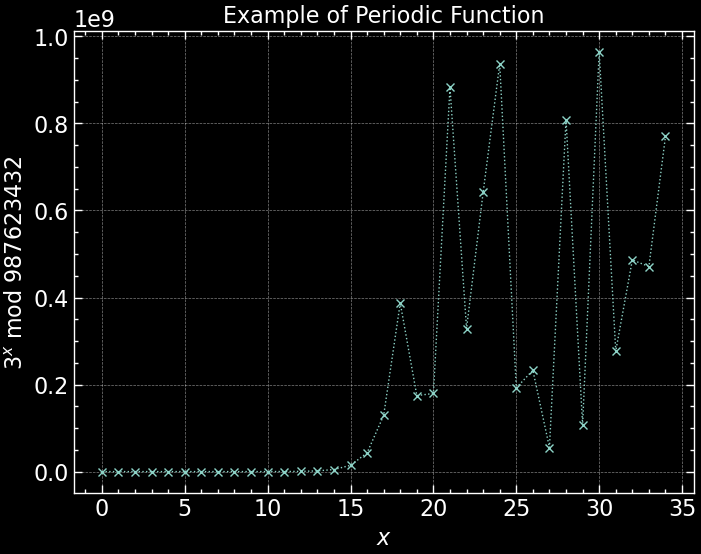

In [6]:
N = 987623432
a = 3

x_vals = np.arange(35)
y_vals = [np.mod(a ** x, N) for x in x_vals]

fig, ax = plt.subplots()

ax.plot(x_vals, y_vals, linewidth = 1, linestyle = 'dotted', marker = 'x')
ax.set(xlabel = '$x$', ylabel = f'${a}^x$ mod ${N}$', title = r"Example of Periodic Function")

try: 
    r = y_vals[1:].index(1) + 1
    plt.annotate('', xy = (0,1), xytext = (r,1), arrowprops = dict(arrowstyle = '<->'))
    plt.annotate(f'$r={r}$', xy = (r / 3,1.5))

except ValueError:
    print('Could not find period, check a < N and have no common factors.')

Shor uses Quantum Phase Estimation on the Unitary Operator $\hat U$ to arrive at the solution: $$U\ket y=\ket{ay\mod N}$$ If we start at $y=\ket{1}$, for $a=3$ and $N=987623432$, this becomes $$U\ket 1=\ket{3\mod 987623432}=\ket{3}$$ After successive applications of $U$:$$U^2\ket{1}$$

Then we create a Quantum Circuit to perform the *Quantum Fourier Transform (QFT)* on the state of the quantum register, a quantum analogue of the Discrete Fourier Transform:

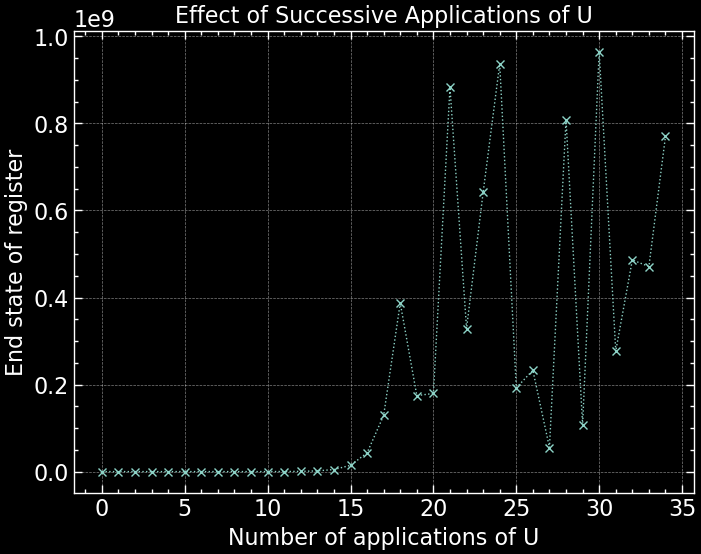

In [7]:
ax.set(xlabel = 'Number of applications of U', ylabel = 'End state of register', title = "Effect of Successive Applications of U")
fig

A superposition of the states in this cycle would be an **eigenstate** of U:$$\ket{u_0}=\frac 1{\sqrt r}\sum_{j=0}^{r-1}\ket{a^j\mod N}$$